## Transformer Architecture

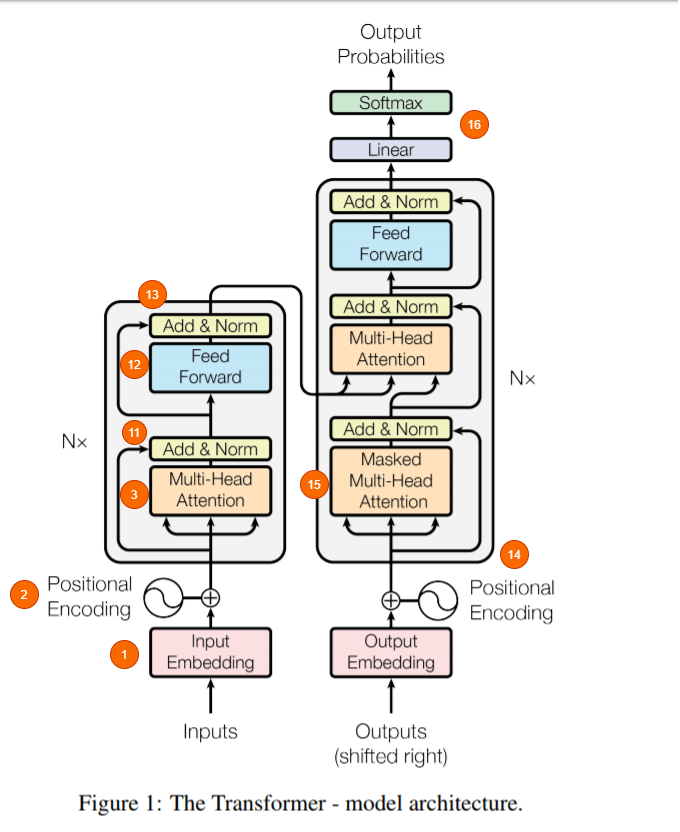

Transformer has two parts, the decoder which is on the left side on the above diagram and the encoder which is on the right.

Imagine we are doing machine translation for now.

The encoder takes the input data (sentence), and produces an intermediate representation of the input.

The decoder decodes this intermediate representation step by step and generates the output. The difference however is in how it is doing this.

Understanding the Encoder section is enough for ViT.

1.   The input data first gets embedded into a vector. The embedding layer helps us grab a learned vector representation for each word.
2.   In the next stage a positional encoding is injected into the input embeddings. This is because a transformer has no idea about the order of the sequence that is being passed as input - for example a sentence.
3.   Now the multi-headed attention is where things get a little different.

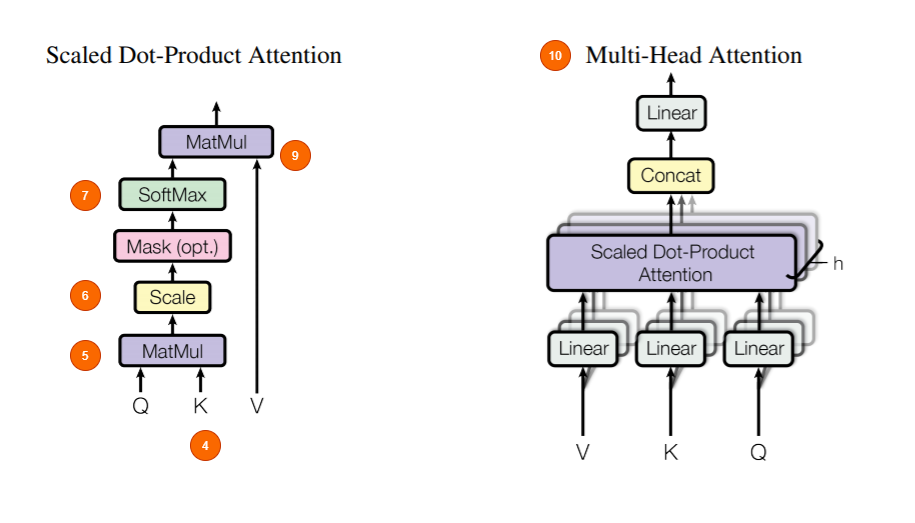

4.   Multi-Headed Attention consists of three learnable vectors. Query, Key and Value vectors. The motivation of this reportedly comes from information retrival where you search (query) and the search engine compares your query with a key and responds with a value.
5.   The Q and K representations undergo a dot product matrix multiplication to produce a score matrix which represents how much a word has to attend to every other word. Higher score means more attention and vice-versa.
6.   Then the Score matrix is scaled down according to the dimensions of the Q and K vectors. This is to ensure more stable gradients as multiplication can have exploding effects.
7.   Next the Score matrix is softmaxed to turn attention scores into probabilities. Obviously higher scores are heightened and lower scores are depressed. This ensures the model to be confident on which words to attend to.
8.   Then the resultant matrix with probabilites is multiplied with the value vector. This will make the higher probaility scores the model has learned to be more important. The low scoring words will effectively drown out to become irrelevant.
9.   Then, the concatenated output of QK and V vectors are fed into the Linear layer to process further.
10.   Self-Attention is performed for each word in the sequence. Since one doesn't depend on the other a copy of the self attention module can be used to process everything simultaneously making this multi-headed.
11.   Then the output value vectors are concatenated and added to the residual connection coming from the input layer and then the resultant respresentation is passed into a LayerNorm for normalization. (Residual connection help gradients flow through the network and LayernNorm helps reduce the training time by a small fraction and stabilize the network)
12.   Further, the output is passed into a point-wise feed forward network to obtain an even richer representation.
13.   The outputs are again Layer-normed and residuals are added from the previous layer.
14.   The output from the encoder along with the inputs (if any) from the previous time steps/words are fed into the decoder where the outputs undergo masked-multi headed attention before being fed into the next attention layer along with the output from encoder.
15.   Masked multi headed attention is necessary because the network shouldn't have any visibility into the words that are to come later in the sequence while decoding, to ensure there is no leak. This is done by masking the entries of words that come later in the series in the Score matrix. Current and previous words in the sequence are added with 1 and the future word scores are added with -inf. This ensures the future words in the series get drowned out into 0 when performing softmax to obtain the probabilities, while the rest are retained.
16.   There are residual connections here as well, to improve the flow of gradients. Finally the output is sent to a Linear layer and softmaxed to obtain the outputs in probabilities.



Unlike words/sentences/paragraphs, images contain much much more information in them basically in form of pixels.
It would be very hard, even with current hardware to attend to every other pixel in the image.
Instead, a popular alternative was to use localized attention.
In fact CNNs do something very similar through convolutions and the receptive field essentially grows bigger as we go deeper into the model's layers, but Tranformers were always going to be computationally more expensive than CNNs because of the' nature of Transformers. And of course, we know how incredibly much CNNs have contributed to the current advancements in Computer Vision.

Google researchers have proposed something different in their paper than can possibly be the next big step in Computer Vision. They show that the reliance on CNNs may not be necessary anymore. So, let's dive right in and explore more about Vision Transformers.

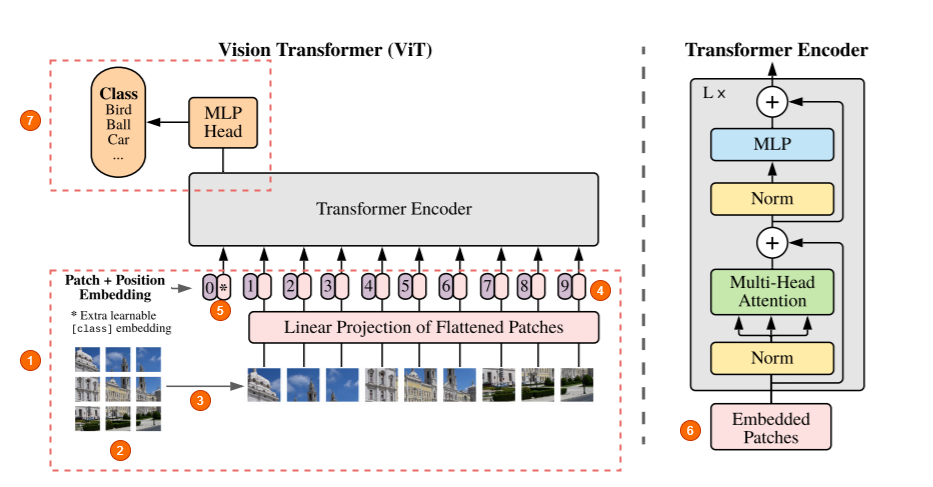

1.   They are only using the Encoder part of the transformer but the difference is in how they are feeding the images into the network.
2.   They are breaking down the image into fixed size patches. So one of these patches can be of dimension 16x16 or 32x32 as proposed in the paper. More patches means more simpler it is to train these networks as the patches themselves get smaller. Hence we have that in the title - "An Image is worth 16x16 words".
3.   The patches are then unrolled (flattened) and sent for further processing into the network.
4.   Unlike NNs here the model has no idea whatsoever about the position of the samples in the sequence, here each sample is a patch from the input image. So the image is fed along with a positional embedding vector and into the encoder. One thing to note here is the positional embeddings are also learnable so you don't actually feed hard-coded vectors w.r.t to their positions.
5.   There is also a special token at the start just like BERT.
6.   So each image patch is first unrolled (flattened) into a big vector and gets multiplied with an embedding matrix which is also learnable, creating embedded patches. And these embedded patches are combined with the positional embedding vector and that gets fed into the Tranformer.
7.   With the only difference being, instead of a decoder the output from the encoder is passed directly into a Feed Forward Neural Network to obtain the classification output.

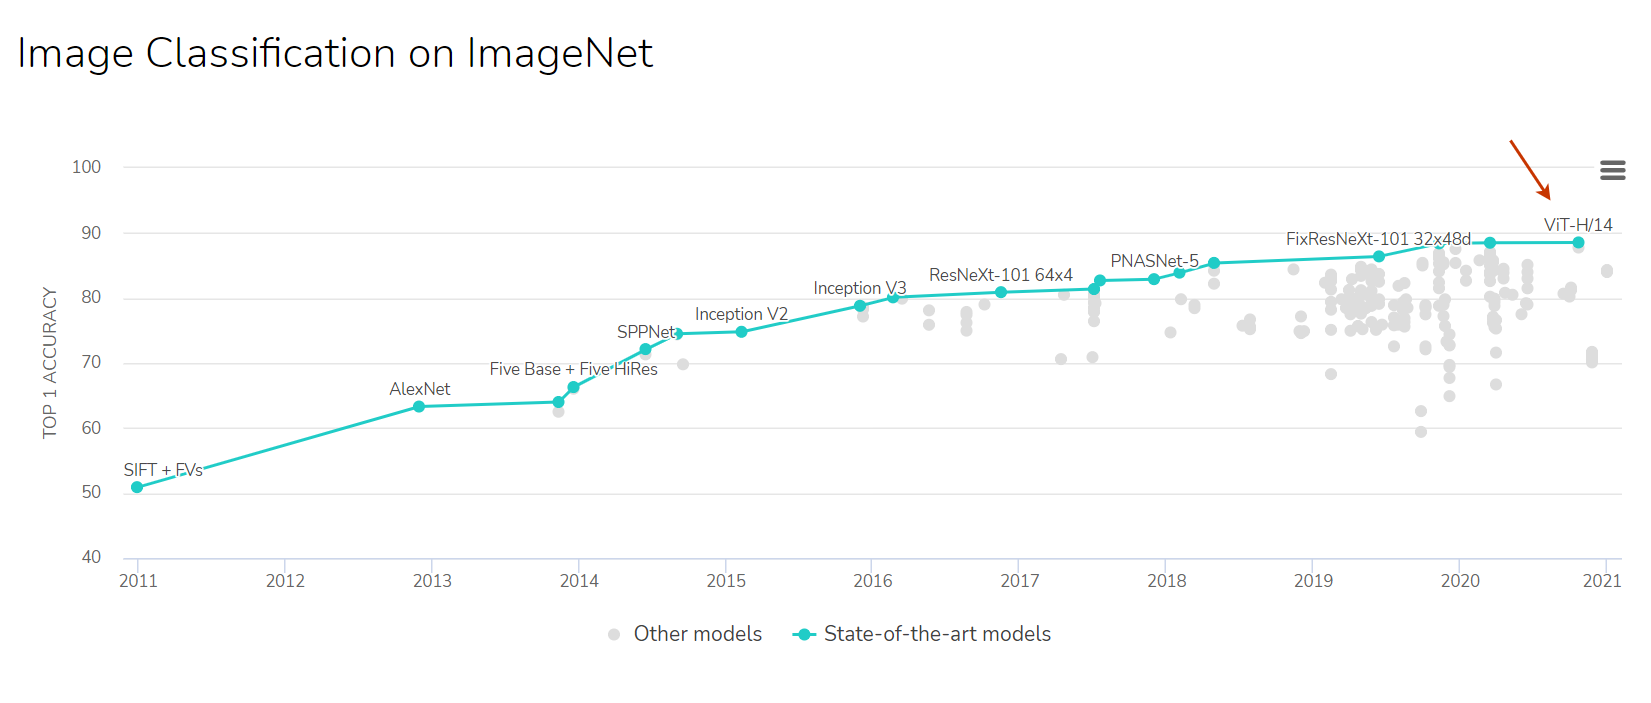


## Vision Transformer (ViT)
1. Split an image into a grid of sub-image patches
1. Embed each patch with a linear projection
1. Each embedded patch becomes a token, and the resulting sequence of embedded patches is the sequence you pass to the model.

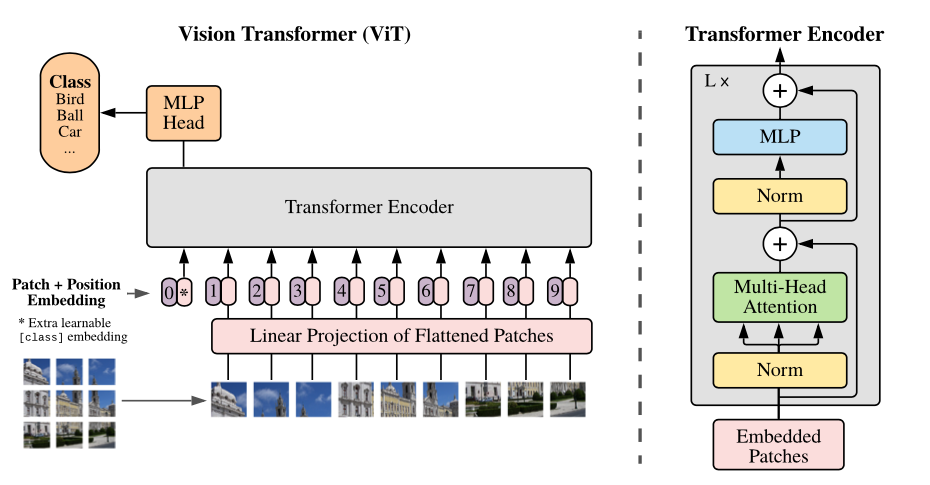

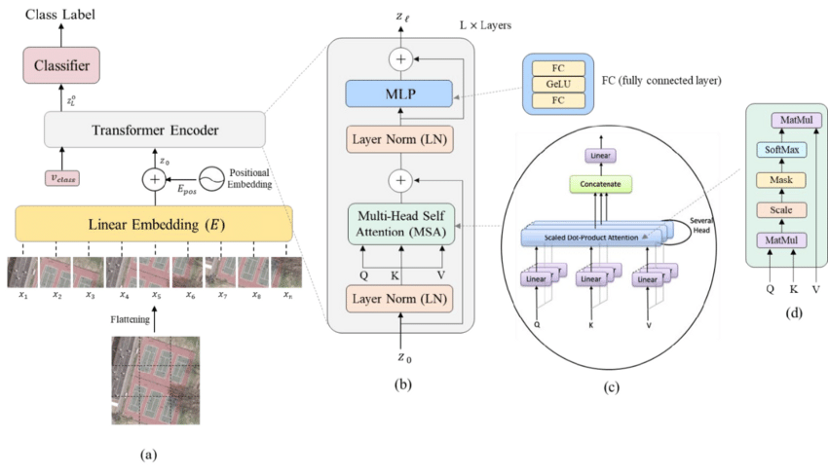

## Import Library

In [111]:
import random
import torch
import numpy as np
from datasets import load_dataset
from datasets import load_metric
from transformers import ViTForImageClassification
from transformers import TrainingArguments
from transformers import Trainer
from PIL import ImageDraw, ImageFont, Image
from transformers.utils.dummy_vision_objects import ImageGPTFeatureExtractor
from transformers import ViTFeatureExtractor

## Load a dataset
load our database : [link text](https://huggingface.co/datasets/beans)

Beans leaf dataset with images of diseased and health leaves.



In [112]:
ds = load_dataset('beans')
ds

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

1. `image`: A PIL Image
1. `image_file_path`: The `str` path to the image file that was loaded as `image`
1. `labels`

In [113]:
ex = ds['train'][30]
ex

{'image_file_path': '/root/.cache/huggingface/datasets/downloads/extracted/b0a21163f78769a2cf11f58dfc767fb458fc7cea5c05dccc0144a2c0f0bc1292/train/bean_rust/bean_rust_train.60.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x7F29000CC510>,
 'labels': 1}

look at the image :

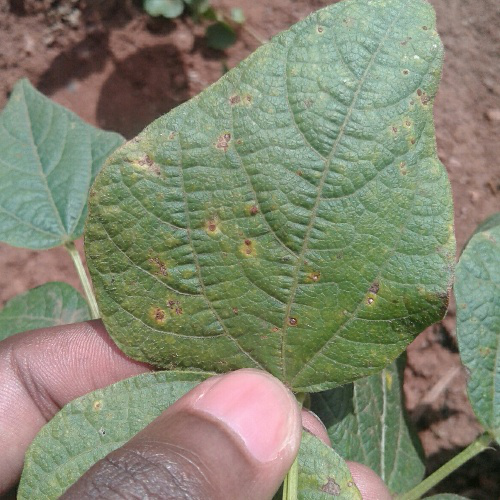

In [114]:
image = ex['image']
image

all `'labels'` we have :

In [115]:
labels = ds['train'].features['labels']
labels

ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)

print `ClassLabel` of 30 image in tran dataset :

In [116]:
labels.int2str(ex['labels'])

'bean_rust'

show example of database :


- Angular Leaf Spot: Has irregular brown patches
- Bean Rust: Has circular brown spots surrounded with a white-ish yellow ring
- Healthy: looks healthy

1 - lable is : bean_rust


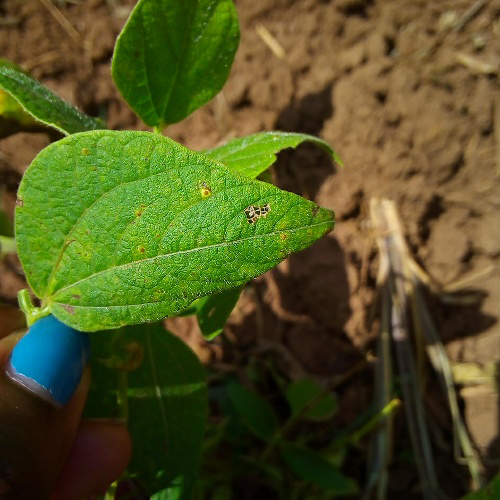

2 - lable is : bean_rust


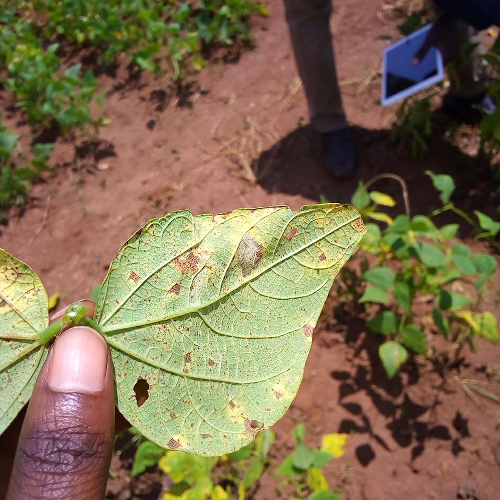

3 - lable is : healthy


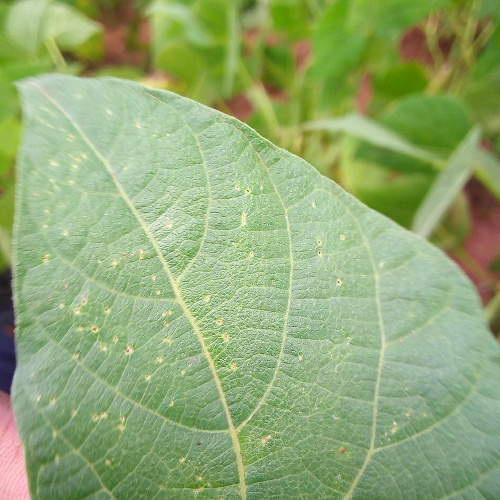

4 - lable is : healthy


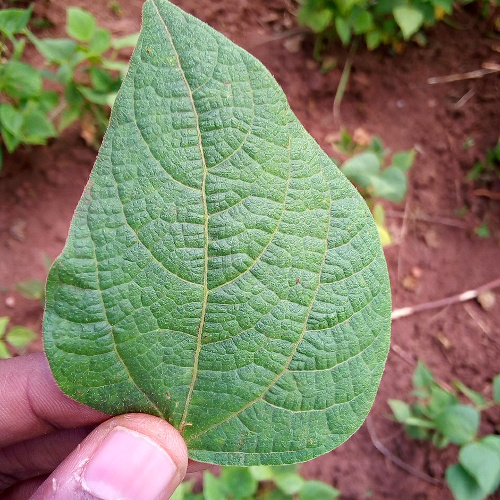

5 - lable is : healthy


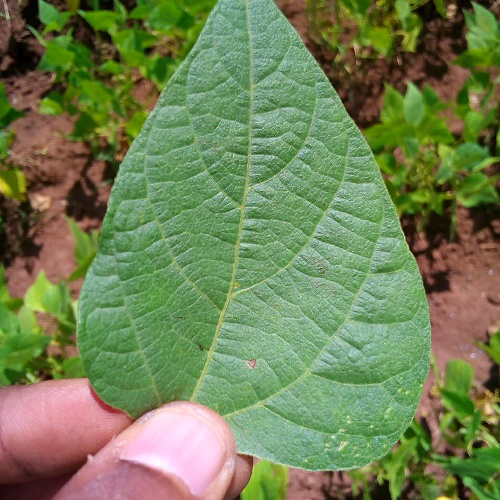

In [117]:
for i in range(0,5):
  ex = ds['train'][random.randint(0,len(ds['train'])-1)]
  image = ex['image']
  print("{} - lable is : ".format(i+1) + labels.int2str(ex['labels']))
  display(image)


## Loading ViT Feature Extractor

we will use a [`ViTFeatureExtractor`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=classlabel#datasets.ClassLabel.int2str) initialized with a configuration that was saved along with the pretrained model we plan to use. In our case, we'll be using the [google/vit-base-patch16-224-in21k](https://huggingface.co/google/vit-base-patch16-224-in21k) model .

Vision Transformer (ViT) model pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224. It was introduced in the paper An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale by Dosovitskiy et al. and first released in this repository. However, the weights were converted from the timm repository by Ross Wightman, who already converted the weights from JAX to PyTorch. Credits go to him.

In [118]:
model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/1ba429d32753f33a0660b80ac6f43a3c80c18938/preprocessor_config.json
Feature extractor ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}



## Processing the Dataset

we write a function that will put those two things together to process a single example from the dataset.

First, though, we'll need to update our last function to accept a batch of data, as that's what `ds.with_transform` expects.

We can directly apply this to our dataset using `ds.with_transform(transform)`.

To process an image, simply pass it to the feature extractor's call function. This will return a dict containing `pixel values`, which is the numeric representation of your image that we'll pass to the model.

We get a numpy array by default, but if we add the `return_tensors='pt'` argument, we'll get back `torch` tensors instead.


In [119]:
ds = load_dataset('beans')

def transform(example_batch):
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')
    inputs['labels'] = example_batch['labels']
    return inputs

prepared_ds = ds.with_transform(transform)

  0%|          | 0/3 [00:00<?, ?it/s]

In [120]:
prepared_ds['train'][0:2]

{'pixel_values': tensor([[[[-0.7647, -0.7569, -0.7333,  ...,  0.3569,  0.3647,  0.3020],
          [-0.7412, -0.7412, -0.7333,  ...,  0.3255,  0.3098,  0.2549],
          [-0.7255, -0.7176, -0.7255,  ...,  0.3255,  0.2627,  0.2863],
          ...,
          [-0.4431, -0.4353, -0.4039,  ..., -0.5529, -0.5451, -0.7176],
          [-0.3725, -0.3882, -0.3725,  ..., -0.5686, -0.6000, -0.7490],
          [-0.2863, -0.3647, -0.3333,  ..., -0.5843, -0.7176, -0.7647]],

         [[-0.5529, -0.5608, -0.5608,  ..., -0.1765, -0.1608, -0.2157],
          [-0.5529, -0.5451, -0.5451,  ..., -0.2078, -0.2157, -0.2784],
          [-0.5373, -0.5216, -0.5294,  ..., -0.2235, -0.2706, -0.2471],
          ...,
          [-0.7647, -0.7569, -0.7333,  ..., -0.3255, -0.3490, -0.5216],
          [-0.7176, -0.7333, -0.7255,  ..., -0.3412, -0.3961, -0.5373],
          [-0.6392, -0.7255, -0.6941,  ..., -0.3569, -0.5059, -0.5608]],

         [[-1.0000, -0.9843, -0.9686,  ..., -0.1843, -0.1451, -0.2000],
          [-0

## Training and Evaluation

- Define a collate function.

- Define an evaluation metric

- Load a pretrained checkpoint.

- Define the training configuration.

### Define our data collator

Batches are coming in as lists of dicts, so we just unpack + stack those into batch tensors.

We return a batch `dict` from our `collate_fn` so we can simply `unpack` the inputs to our model later.

In [121]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

### Define an evaluation metric

Here, we load the `accuracy` metric from `datasets`, and then write a function that takes in a model prediction and computes the accuracy.

In [122]:
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

Now we can load our pretrained model.

We'll add `num_labels` on init to make sure the model creates a classification head with the right number of units. We'll also include the `id2label` and `label2id`.

In [123]:
labels = ds['train'].features['labels'].names
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/1ba429d32753f33a0660b80ac6f43a3c80c18938/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "angular_leaf_spot",
    "1": "bean_rust",
    "2": "healthy"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "angular_leaf_spot": "0",
    "bean_rust": "1",
    "healthy": "2"
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.24.0"
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/m

The last thing we'll do before that is set up the training configuration by defining [`TrainingArguments`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments).

In [124]:
training_args = TrainingArguments(
  output_dir="./vit-base-beans-demo-v5",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

PyTorch: setting up devices


Now, all instances can be passed to Trainer and we are ready to start training!



In [125]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

Using cuda_amp half precision backend


In [126]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1034
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 260
  Number of trainable parameters = 85800963


***** Running Evaluation *****
  Num examples = 133
  Batch size = 8
Saving model checkpoint to ./vit-base-beans-demo-v5/checkpoint-100
Configuration saved in ./vit-base-beans-demo-v5/checkpoint-100/config.json
Model weights saved in ./vit-base-beans-demo-v5/checkpoint-100/pytorch_model.bin
Feature extractor saved in ./vit-base-beans-demo-v5/checkpoint-100/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 133
  Batch size = 8
Saving model checkpoint to ./vit-base-beans-demo-v5/checkpoint-200
Configuration saved in ./vit-base-beans-demo-v5/checkpoint-200/config.json
Model weights saved in ./vit-base-beans-demo-v5/checkpoint-200/pytorch_model.bin
Feature extractor saved in ./vit-base-beans-demo-v5/checkpoint-200/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./vit-base-beans-demo-v5/checkpoint-200 (score: 0.02174561098217964).
Saving model checkpoint to ./vit-base-beans-demo-v5


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 298497957GF
  train_loss               =       0.151
  train_runtime            =  0:02:04.65
  train_samples_per_second =       33.18
  train_steps_per_second   =       2.086


In [127]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 133
  Batch size = 8


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =        1.0
  eval_loss               =     0.0217
  eval_runtime            = 0:00:02.05
  eval_samples_per_second =     64.719
  eval_steps_per_second   =      8.272


In [128]:
metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 128
  Batch size = 8


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9766
  eval_loss               =     0.0905
  eval_runtime            = 0:00:02.19
  eval_samples_per_second =     58.233
  eval_steps_per_second   =      7.279


## Reference

1.   [Vision Transformer (ViT)](https://huggingface.co/docs/transformers/model_doc/vit)
1.   [Illustrated Guide to Transformers- Step by Step Explanation](https://towardsdatascience.com/illustrated-guide-to-transformers-step-by-step-explanation-f74876522bc0)
1.   [Vision Transformer for Image Classification](https://www.youtube.com/watch?v=HZ4j_U3FC94)
1.   [Multi-head attention mechanism: “queries”, “keys”, and “values,” over and over again](https://data-science-blog.com/blog/2021/04/07/multi-head-attention-mechanism/)
1.   [Vision Transformers from Scratch (PyTorch): A step-by-step guide](https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c)